In [192]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from datetime import timezone
import requests
from io import StringIO
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import tensorflow as tf

In [193]:
# defining stonks and dates. change to user input later
stonk_code = 'AMC'
hist_date = '01-01-2010'
today = dt.today()

In [194]:
# converting dates to Unix timestamps
unix_hist = dt.strptime(hist_date,'%m-%d-%Y').replace(tzinfo=timezone.utc).timestamp()
unix_today = today.replace(tzinfo=timezone.utc).timestamp()

In [195]:
# getting stonk history from Yahoo! Finance
link = (f'https://query1.finance.yahoo.com/v7/finance/download/'
        f'{stonk_code}?period1={int(unix_hist)}&period2={int(unix_today)}&interval=1d&events=history')
b = requests.get(link)
s = str(b.content,'utf-8')
s_io = StringIO(s)
stonks = pd.read_csv(s_io,encoding='utf-8',parse_dates=['Date'])

In [196]:
# defining how far ahead user wants to predict
days_ahead = 30 # change to user input
stonks[f'{days_ahead}_days'] = np.nan
for ind in stonks.index:
    try:
        stonks.loc[ind,f'{days_ahead}_days'] = stonks.loc[ind+days_ahead,'Open']
    except:
        pass

In [197]:
# converting Date column to numeric data
try:
    stonks['Date'] = stonks['Date'].map(dt.toordinal)
except:
    pass

In [198]:
# defining independent & dependent variables, train/test split
x = stonks.dropna().loc[:,['Date','Open','High']]
y = stonks.dropna().loc[:,f'{days_ahead}_days']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

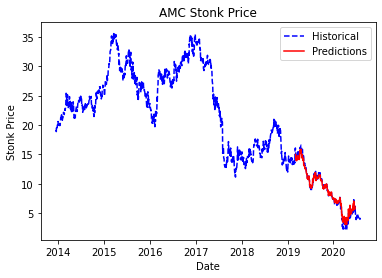

Score: 0.6641724396918274


In [199]:
# model & predictions
lm = LinearRegression()
model = lm.fit(x_train,y_train)
test_predictions = lm.predict(x_test)
plt.plot(stonks.Date.map(dt.fromordinal),stonks.Open,'b--',label='Historical')
plt.plot(x_test.Date.map(dt.fromordinal),test_predictions,'r-',label='Predictions')
plt.xlabel('Date')
plt.ylabel('Stonk Price')
plt.title(f'{stonk_code} Stonk Price')
plt.legend(loc=0,frameon=True)
plt.show()
score = model.score(x_test,y_test)
print('Score:',score)

In [200]:
# predicting future stonks
pred_date = '08-18-2020' # change to user input
unix_pred = dt.strptime(pred_date,'%m-%d-%Y').replace(tzinfo=timezone.utc).timestamp()
print(range(int(unix_today),int(unix_pred)))

range(1596491444, 1597708800)


In [201]:
stonks

,Date,Open,High,Low,Close,Adj Close,Volume,30_days
0,735220,19.180000,19.790001,18.900000,18.900000,13.593408,5457200,21.500000
1,735221,18.900000,19.490000,18.809999,19.490000,14.017756,1605400,21.049999
2,735222,19.650000,19.770000,19.400000,19.680000,14.154408,737100,20.840000
3,735225,19.790001,19.990000,19.500000,19.740000,14.197564,698100,20.990000
4,735226,19.740000,19.820000,19.500000,19.530001,14.046525,213700,21.209999
...,...,...,...,...,...,...,...,...
1662,737634,3.850000,4.250000,3.840000,4.150000,4.150000,6226600,NaN
1663,737635,4.070000,4.200000,3.950000,4.160000,4.160000,5489400,NaN
1664,737636,4.120000,4.340000,4.060000,4.120000,4.120000,3699100,NaN
1665,737637,4.080000,4.150000,3.950000,4.040000,4.040000,2584900,NaN


In [202]:
stonks_zscore = (stonks - stonks.mean()) / stonks.std()
stonks_zscore

,Date,Open,High,Low,Close,Adj Close,Volume,30_days
0,-1.732549,-0.146970,-0.112605,-0.137880,-0.176864,-0.426163,1.100337,0.121379
1,-1.731118,-0.179519,-0.147279,-0.148410,-0.108364,-0.355095,-0.021170,0.069537
2,-1.729686,-0.092335,-0.114917,-0.079380,-0.086304,-0.332209,-0.273988,0.045345
3,-1.725391,-0.076060,-0.089489,-0.067680,-0.079338,-0.324982,-0.285344,0.062625
4,-1.723959,-0.081873,-0.109138,-0.067680,-0.103720,-0.350277,-0.426384,0.087970
...,...,...,...,...,...,...,...,...
1662,1.723657,-1.929014,-1.908696,-1.899901,-1.889375,-2.007703,1.324359,NaN
1663,1.725088,-1.903440,-1.914475,-1.887031,-1.888214,-2.006028,1.109713,NaN
1664,1.726520,-1.897628,-1.898294,-1.874161,-1.892858,-2.012727,0.588441,NaN
1665,1.727952,-1.902278,-1.920254,-1.887031,-1.902146,-2.026125,0.264026,NaN


In [212]:
stonks_train = stonks_zscore.dropna()
target = stonks_train.pop(f'{days_ahead}_days')
x_train, x_test, y_train, y_test = train_test_split(stonks_train,target,test_size=0.2,shuffle=False)
y_train, y_test = y_train.values, y_test.values
x_train = np.reshape(x_train.values,(x_train.values.shape[0],x_train.values.shape[1],1))
x_test = np.reshape(x_test.values,(x_test.values.shape[0],x_test.values.shape[1],1))

In [242]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(units=256,return_sequences=True))
model_lstm.add(tf.keras.layers.LSTM(units=256,return_sequences=True))
model_lstm.add(tf.keras.layers.LSTM(units=256))
model_lstm.add(tf.keras.layers.Dense(units=1))
model_lstm.compile(loss='mse',optimizer='adam')

In [243]:
model_lstm.fit(x_train,y_train,epochs=10,batch_size=512,verbose=1)

Epoch 1/10
3/3 [==============================] - 1s 195ms/step - loss: 0.6154
Epoch 2/10
3/3 [==============================] - 1s 191ms/step - loss: 0.3162
Epoch 3/10
3/3 [==============================] - 1s 188ms/step - loss: 0.2581
Epoch 4/10
3/3 [==============================] - 1s 192ms/step - loss: 0.2540
Epoch 5/10
3/3 [==============================] - 1s 188ms/step - loss: 0.2028
Epoch 6/10
3/3 [==============================] - 1s 191ms/step - loss: 0.1859
Epoch 7/10
3/3 [==============================] - 1s 191ms/step - loss: 0.1478
Epoch 8/10
3/3 [==============================] - 1s 189ms/step - loss: 0.1437
Epoch 9/10
3/3 [==============================] - 1s 188ms/step - loss: 0.1187
Epoch 10/10
3/3 [==============================] - 1s 188ms/step - loss: 0.1247


In [244]:
model_lstm.evaluate(x_test,y_test,verbose=1)

11/11 [==============================] - 0s 21ms/step - loss: 0.0517: 0s - loss: 0.051


0.05174208804965019

In [245]:
to_predict = stonks_zscore[pd.isnull(stonks_zscore[f'{days_ahead}_days'])]
to_predict.drop(f'{days_ahead}_days',axis=1,inplace=True)
x_predict = np.reshape(to_predict.values,(to_predict.values.shape[0],to_predict.values.shape[1],1))
predictions = model_lstm.predict(x_predict)

c:\users\nolan\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


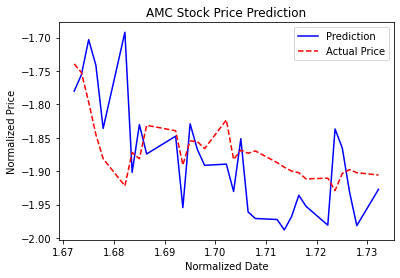

In [248]:
plt.plot(to_predict.Date,predictions,'b-',label='Prediction')
plt.plot(stonks_zscore.loc[to_predict.index,'Date'],stonks_zscore.loc[to_predict.index,'Open'],'r--',label='Actual Price')
plt.legend(loc=0,frameon=True)
plt.title('AMC Stock Price Prediction')
plt.xlabel('Normalized Date')
plt.ylabel('Normalized Price')
plt.show()